# <u>***Real Estate Analytics: Homework 2 (REITs)*** </u>

## General Guidlines: 

- All the data you will need has already been downloaded for you
- Refer to the functions in the code given to you. The entire homework is based on the codes you already have and requires smart changes in code on your part. However, you are free to write your own code. 
- For some questions, you already have some code in this document. Use it directly and answer the questions
-  These questions do not require the use of research grid

In [45]:
import sys, os
module_path = os.path.abspath(os.path.join("..", ".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from Code.settings import *
import Code.read_data as dataReader
import Code.Util as util
import Code.alpha_momentum as am
import matplotlib.pyplot as plt

dataReader.pd.options.mode.chained_assignment = None
from IPython.display import display, Markdown, Latex, HTML

display(HTML("<style>pre { white-space: pre !important; }</style>"))

# 1. Risk and Return performance of REITs during regimes of the yield curve

#### Tasks
- Write a code to check whether the regime is bull/bear flattener/steepner and compare the risk and return performance of Equity REITs in these regimes. An excellent description of what bull and bear flatteners and steepeners are can be found here: https://learnbonds.com/news/bull-flattener-bear-flattener-bull-steepener-and-bear-steepener-explained/
- Print the monthly regimes from December 2019 onward

#### Notes:
##### Step 1:

- Write a function to obtain the four regimes. To do this, you will need two timeseries: the 2 year yields and the 10 year yields. 
- For "Long term-yields" use 10y yields (DGS10 from FRED), for "Short-term yields", use 2Y yields (DGS2 from FRED). We have used these files in the class and they are downloaded in the other_data folder. If you need help in loading and cleaning the functions, refer function read_yields() in read_data.py
- Calcuclating the 4 regimes requires you to calculate two measures.
- First is the Slope. You can define this as the change in DGS10. Define this change as the difference between DGS10 over the last quarter and DGS10 over the entire year. (i.e. the slope of yield curve will be defined as the difference between 3M Moving Average and 12M Moving Average)
- Second is the change in spread. You can define the spread as the difference between DGS10 and DGS2 (you might want to use 3 Month Moving average instead of point-in-time values)
- If there is a conflict between the direction of 10Y yields and 2Y yields, i.e. if say the 10Y yields are increasing, but the 2Y yields are decreasing, consider the 10Y yields.
- Print the regimes from December 2019 onward

##### Step 2:
- For Risk and Return performance, use 'All Equity REIT' and calculate annualized mean return, annual vol and Sharpe.
- For returns, use groupby and mean. Don't forget to annualized the returns by multiplying with the 12 (since it is monthly) and the volatility by sqrt(12). Sharpe is defined as annualized returns/annualized vol.

In [61]:
def get_yield_regime():
    
    # Load 10-Y and 2-Y yields
    ####################### START YOUR CODE #######################
    DGS2 = dataReader.read_yields('DGS2.csv')
    DGS10 = dataReader.read_yields('DGS10.csv')
    DGS = DGS2.merge(DGS10, on='Date')
    ######################## END YOUR CODE ########################

    DGS['DGS10_12M'] = DGS['DGS10'].rolling(12).mean()
    DGS['DGS2_12M'] = DGS['DGS2'].rolling(12).mean()
    
    # Calculate 3 Month Rolling Avearge
    ####################### START YOUR CODE #######################
    DGS['DGS10_3M'] = DGS['DGS10'].rolling(3).mean()  # rolling mean for 10-Y yield
    DGS['DGS2_3M'] = DGS['DGS2'].rolling(3).mean()  # rolling mean for 2-Y yield
    ######################## END YOUR CODE ########################
    
    # Calculate Slope and Change in Spread
    ####################### START YOUR CODE #######################    
    DGS['DGS10_Change'] = DGS['DGS10_12M'] - DGS['DGS10_3M']  # 10-Y yield change, long-run - short-run
    DGS['Spread'] = abs(DGS['DGS10_3M'] - DGS['DGS2_3M'])  # yield spread
    DGS['Spread_change'] = DGS.Spread.diff()  # change in spread
    ######################## END YOUR CODE ########################
    
    DGS['Sentiment'], DGS['Slope'] = np.nan, np.nan
    DGS.loc[DGS['DGS10_Change'] > 0, 'Sentiment'] = 'Bear'
    DGS.loc[DGS['DGS10_Change'] <= 0, 'Sentiment'] = 'Bull'
    
    # Determine Steepener or Flatterner
    ####################### START YOUR CODE #######################
    DGS.loc[DGS['Spread_change'] > 0, 'Slope'] = "Steepener"
    DGS.loc[DGS['Spread_change'] <= 0, 'Slope'] = "Flatterner"
    ######################## END YOUR CODE ########################
    
    DGS['Regime'] = DGS['Sentiment'] + ' ' + DGS['Slope']
    return DGS[['Date', 'Regime']].dropna().iloc[:-1]

In [62]:
yield_curve_regimes = get_yield_regime()
equity_reit = dataReader.fetch_data(file_name='Cumulative', series_type='Total Return', data_name='AllEquity').reset_index()

# Merge equity_reit with yield_curve_regimes
####################### START YOUR CODE #######################
equity_reit = equity_reit.merge(yield_curve_regimes, on='Date')
######################## END YOUR CODE ########################

/tmp/ipykernel_190207/2249946762.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Bear' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  DGS.loc[DGS['DGS10_Change'] > 0, 'Sentiment'] = 'Bear'
/tmp/ipykernel_190207/2249946762.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Steepener' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  DGS.loc[DGS['Spread_change'] > 0, 'Slope'] = "Steepener"


In [63]:
# Print regimes
####################### START YOUR CODE #######################
equity_reit[equity_reit.Date > dt.datetime(2019,11,30)]
######################## END YOUR CODE ########################

,Date,Total Return,Regime
511,2019-12-31,0.006134,Bear Steepener
512,2020-01-31,0.012652,Bear Steepener
513,2020-02-29,-0.070257,Bear Steepener
514,2020-03-31,-0.186847,Bear Steepener
515,2020-04-30,0.088296,Bear Steepener
516,2020-05-31,0.017105,Bear Steepener
517,2020-06-30,0.023096,Bear Steepener
518,2020-07-31,0.038163,Bear Steepener
519,2020-08-31,0.001366,Bear Steepener
520,2020-09-30,-0.026631,Bear Steepener


In [49]:
def get_performance(df):
    # calculate mean and volatity by regime
    ####################### START YOUR CODE #######################
    mean_returns = df.groupby("Regime")['Total Return'].mean() * 12
    vol_returns = df.groupby("Regime")['Total Return'].std() * np.sqrt(12)
    ######################## END YOUR CODE ########################
    
    sharpe = (mean_returns / vol_returns).to_frame('Sharpe')
    mean_returns = mean_returns.to_frame('Mean Returns')
    vol_returns = vol_returns.to_frame('Vol')
    return mean_returns.join(vol_returns).join(sharpe)

performance_yield_regimes = get_performance(equity_reit)
display(performance_yield_regimes.round(3))

,Mean Returns,Vol,Sharpe
Regime,,,
Bear Flatterner,0.168,0.161,1.041
Bear Steepener,0.113,0.186,0.608
Bull Flatterner,0.186,0.141,1.318
Bull Steepener,0.007,0.202,0.033


# 2. Risk-Return performance of REITs during different volatility regimes

In this Question, we will study the performance of REITs during various volatility regimes.

#### Tasks:

- Use function get_vix_regimes() below to obtain monthly volatility regimes. Based on the code given and your understandig of volatility, interpret these regimes. I.e. what is your understanding of R1,2,3,4 in terms of volatility. 
- Calculate the risk and return performance for 'Equity REIT' during each of these regimes. 
- Calculate and compare the sharpe ratios for 4 major sectors, i.e. Industrial, Apartments, Retail and Office during these regimes. What do you observe?

#### Hints:

- For Risk and Return performance, use 'All Equity REIT' and calculate annualized mean return, annual vol and Sharpe. You should be able to use the same code you wrote for Q1 above.
- For returns, use groupby REGIME and mean. Don't forget to annualized the returns by multiplying with the 12 (since it is monthly) and the volatility by sqrt(12). Sharpe is defined as annualized returns/annualized vol.
- For the four sectors, only Sharpe ratios are expected. Sharpe Ratio calculation can be found in the function add_period_sharpe() in return_analysis.py. Note that Sharpe Ratios = annualized returns divided by annualized vol.

In [50]:
def get_vix_regimes():
    vix = pd.read_csv(os.path.join(output_path, 'other_data', vix_filename))
    vix['Date'] = pd.to_datetime(vix['Date'], format = "%m/%d/%Y")
    vix = vix.set_index('Date').resample('1M').mean().reset_index()
    vix['Date']  = vix['Date'] + pd.offsets.MonthEnd(0)
    vix['Change'] = vix['VIX'] - vix['VIX'].shift()
    vix['VIX_3M_MA'] = vix['VIX'].rolling(3).mean()
    vix['VIX_relative'] = vix['VIX'] - vix['VIX_3M_MA']

    vix['Regime'] = np.nan
    vix.loc[(vix['VIX_relative'] > 0) & (vix['Change'] > 0) , 'Regime'] = 'R1'
    vix.loc[(vix['VIX_relative'] > 0) & (vix['Change'] < 0) , 'Regime'] = 'R2'
    vix.loc[(vix['VIX_relative'] < 0) & (vix['Change'] > 0) , 'Regime'] = 'R3'
    vix.loc[(vix['VIX_relative'] < 0) & (vix['Change'] < 0) , 'Regime'] = 'R4'
    return vix[['Date', 'Regime']].dropna()
    
vix_regimes = get_vix_regimes()
vix_regimes['Regime'] = vix_regimes['Regime'].replace('R1', 'Vol Spike').replace('R2', 'Vol Normalization').replace('R3', 'Vol Build Up').replace('R4', 'Low Risk')

/tmp/ipykernel_190207/1987151058.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'R1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  vix.loc[(vix['VIX_relative'] > 0) & (vix['Change'] > 0) , 'Regime'] = 'R1'


Calculate the risk and return performance for 'Equity REIT' during each of these regimes.
1. R1 = Vol Spike
2. R2 = Vol Normalization
3. R3 = Vol Build up
4. R4 = Low Risk

*Hint: You can use the previously defined function `get_performance()` above.*

In [51]:
vix_regimes.head(5)

,Date,Regime
2,1990-03-31,Low Risk
3,1990-04-30,Vol Build Up
4,1990-05-31,Low Risk
5,1990-06-30,Low Risk
6,1990-07-31,Vol Spike


In [52]:
####################### START YOUR CODE #######################
equity_reit = dataReader.fetch_data(file_name='Cumulative', series_type='Total Return', data_name='AllEquity').reset_index().merge(vix_regimes,on='Date')

performance_vix_regimes = get_performance(equity_reit)
######################## END YOUR CODE ########################

display(performance_vix_regimes.round(3))

,Mean Returns,Vol,Sharpe
Regime,,,
Low Risk,0.270,0.171,1.580
Vol Build Up,0.011,0.169,0.067
Vol Normalization,0.053,0.147,0.364
Vol Spike,-0.051,0.200,-0.256


Above, we see that the returns are lowest and the Sharpe ratio negative during a volatility spike regime. This makes sense as increased volatility is often associated with market crashes. Similarly, we see that returns and the Sharpe ratio are highest in low risk regimes. However, the observed volatility is quite similar across the four periods, with Low Risk having higher volatility than both Vol Build Up and Vol Normalization. 

Calculate and compare the sharpe ratios for 4 major sectors, i.e. Industrial, Apartments, Retail and Office during these regimes. What do you observe?

In [53]:
for i, sector in enumerate(['Office', 'Apartments', 'Retail', 'Industrial']):
    ####################### START YOUR CODE #######################
    sector_reit = dataReader.fetch_data(file_name=sector, series_type="Total Return")
    sector_reit = sector_reit.merge(vix_regimes,on='Date')

    ######################## END YOUR CODE ########################
    
    if i == 0:
        performance_vix_regimes_sector = get_performance(sector_reit).rename(columns = {'Sharpe' : sector})[[sector]]
    else:
        performance_vix_regimes_sector = performance_vix_regimes_sector.join(get_performance(sector_reit).rename(columns = {'Sharpe' : sector})[sector])
        
# Sharpe Ratios for Major Sectors
performance_vix_regimes_sector

,Office,Apartments,Retail,Industrial
Regime,,,,
Low Risk,1.394017,1.397276,1.365353,1.337606
Vol Build Up,0.191320,0.138877,0.066018,0.040934
Vol Normalization,-0.740409,-0.052894,0.392426,0.215482
Vol Spike,-0.465978,-0.080291,-0.315727,-0.307652


Above, we see that all four sectors performed best in the Low Risk regime. All sectors except Office performed worst in the Vol Spike regime, and Office performed worst in the Vol Normalization regime. Overall, Office seems to have the most downside in Vol Spike and Vol Normalization periods. Apartments have the best Sharpe ratio during Vol Spike regimes. This could be because demand for housing is less influenced by market crashes than the other sectors, or because apartment leases are relatively short, which allows landlords to more easily raise rates in high inflation periods. 

# 3. Macroeconomic Factor Model

#### Tasks

- Regress Equity REITs and all sector REITs against a 4 factor model consisting of Industrial Growth, Inflation, Yield Spread Change and Change in Term Spread
- REITs are widely considered inflation hedges. Considering the current high inflation scenario, which REIT should you buy?

#### Notes on Constructing the variables

Sources:

1. https://fred.stlouisfed.org/series/T10Y3M
2. https://fred.stlouisfed.org/series/INDPRO
3. https://fred.stlouisfed.org/series/CPIAUCSL
4. https://fred.stlouisfed.org/series/DBAA
5. https://fred.stlouisfed.org/series/AAA

Note: All these files have been downloaded for you in other_data. Refer functions read_other_macro_data() and read_inflation() in read_data.py for how to read and clean the data

Construct 4 macroeconomic variables from the sources above: 

1. % Inflation from CPI Index. 
2. Industrial Growth from Index of Industrial Production
3. Default Spread as the change in the spread between 3 Month average of Baa and 3 Month average of Aaa corporate bond yield
4. Change in Term Spread as the change in the spread between 3 Month average of 10Y treasuries and 3 Month average of 3 Month (90-Day) Treasury yields

#### Hints: 

- Full Sample regressions on Monthly should be fine. You are not expected to show Rolling regressions.
- You can find the regression function below. Feel free to use it directly.
- Note that you are given the CPI Index. Those are the levels (like stock prices). That is not inflation. You need to get inflation (think about it as calcuclating returns). Same with with Industrial growth rate. 
INDPRO is the index of industrial production, not the growth rate itself. For spread change, you have to use spread CHANGE. So calcuclate the spread and subtract the previous month's spread from it.
- You can use summary_col() function from statsmodels.iolib.summary2 to neatly show the regression results. This is preferred but optional. You can find the syntax online or from lecture notes.

You can also refer to the guidelines below:

In [54]:
# Read CPI Index and calculate inflation
####################### START YOUR CODE #######################
# ----- 2 Lines of code -----
cpi = dataReader.read_other_macro_data('CPIAUCSL.csv')
cpi['Inflation'] = cpi["CPIAUCSL"].pct_change()
######################## END YOUR CODE ########################

# Read Index of Industrial Production and calculate Industrial Growth
####################### START YOUR CODE #######################
# ----- 2 Lines of code -----
indprod = dataReader.read_other_macro_data('INDPRO.csv')
indprod['Indpro_growth'] = indprod.INDPRO.pct_change()
######################## END YOUR CODE ########################

# Read the corproate bond yields and calcuclate the change in default spread
# Note that AAA and DBAA yields are loaded using different functions.
####################### START YOUR CODE #######################
# ----- ~5 lines of code -----
aaa = dataReader.read_other_macro_data("AAA.csv")
baa = dataReader.read_other_macro_data("DBAA.csv")
corporate_yield = aaa.merge(baa, on='Date')
corporate_yield['Spread'] = corporate_yield.DBAA - corporate_yield.AAA
corporate_yield['Spread_Change'] = corporate_yield.Spread.diff()
######################## END YOUR CODE ########################

# Read 10Y and 90-Day yields and calculate change in term spread
####################### START YOUR CODE #######################
# ----- ~2 Lines of code -----
term_spread = dataReader.read_other_macro_data('T10Y3M.csv')
term_spread['Change in Term Spread'] = term_spread.T10Y3M.diff()
######################## END YOUR CODE ########################

macro_data = term_spread.copy(deep = True)

# Merge stuff and rename columns
####################### START YOUR CODE #######################
# ----- ~5 Lines of code -----
macro_data = pd.DataFrame(term_spread.groupby('Date')[['Change in Term Spread']].mean()) # Group by month for the merge
macro_data = macro_data.merge(cpi[['Date','Inflation']], on='Date')
macro_data = macro_data.merge(indprod[['Date','Indpro_growth']], on='Date')
corporate_yield = pd.DataFrame(corporate_yield.groupby('Date')[['Date','Spread_Change']].mean()).reset_index(drop=True) # Group by month for the merge
macro_data = macro_data.merge(corporate_yield[['Date','Spread_Change']], on='Date')  
######################## END YOUR CODE ########################

# Read Equity REIT total returns series
####################### START YOUR CODE #######################
# ----- 1 Line of code -----
equity_reit = dataReader.fetch_data(file_name='Cumulative', series_type='Total Return', data_name='AllEquity').reset_index()
######################## END YOUR CODE ########################

equity_reit = pd.merge(equity_reit, macro_data, on = 'Date', how = 'inner').dropna()

# macro_factors = list(set(macro_data.columns) - {'Date'})
macro_factors = list(macro_data.columns)
macro_factors.remove("Date")

### Note that the data you download and clean should somewhat look like this. I have winsorized the macro variables and taking a 3 Month moving average to keep the plot clean, but you are not expected to do it for the question.

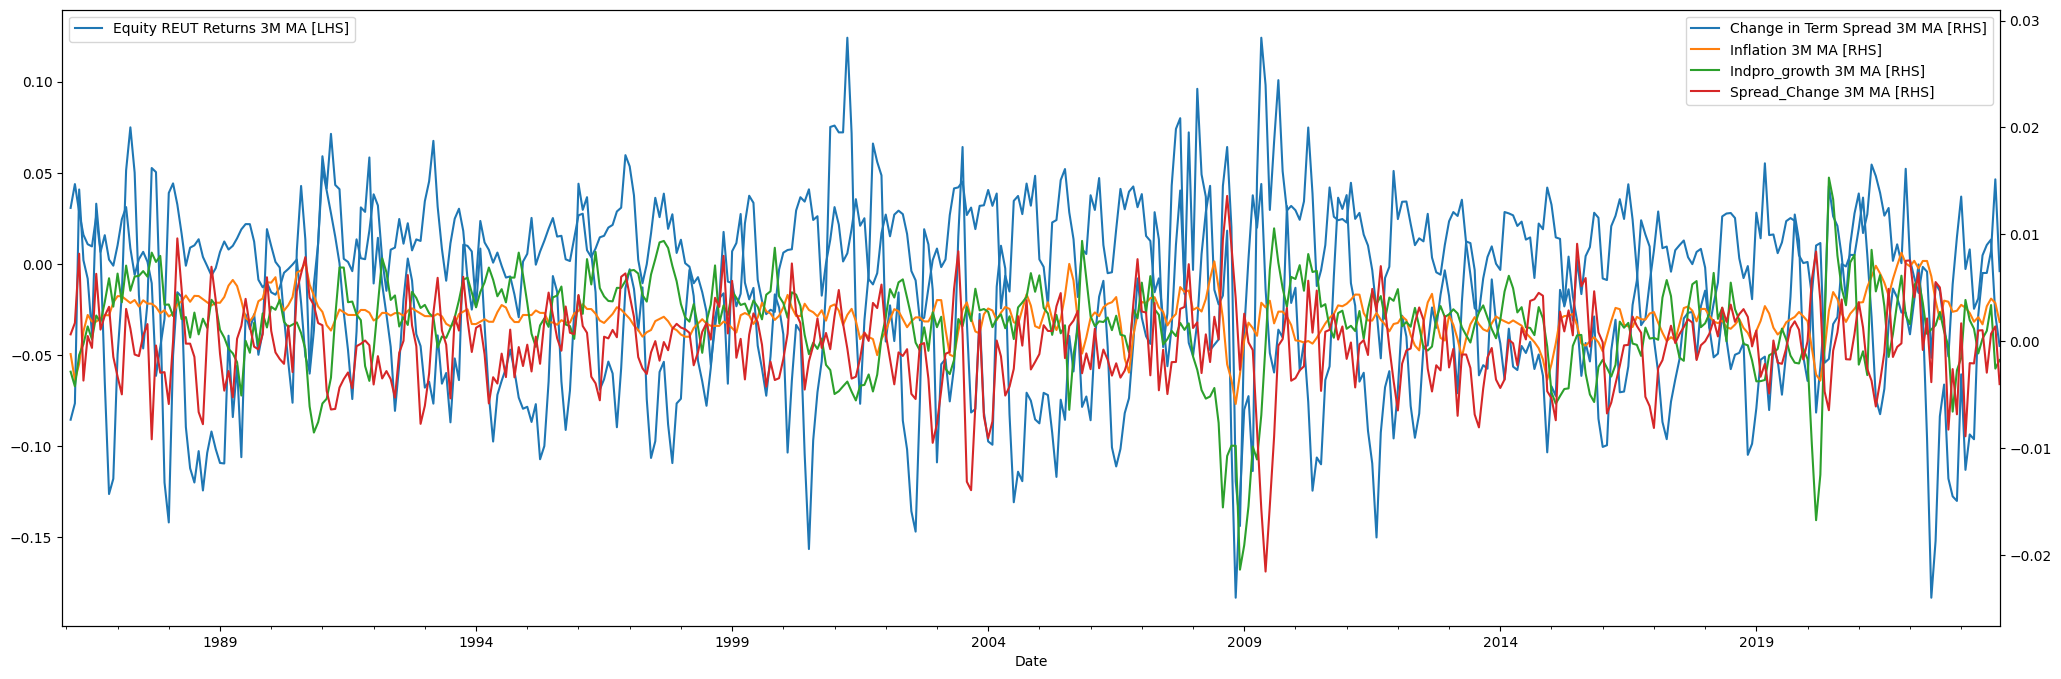

In [55]:
fig, ax = plt.subplots(figsize = (25, 8))
axtwin = ax.twinx()
equity_reit.set_index('Date')['Total Return'].rolling(3).mean().plot(ax = ax)
util.winsorize(equity_reit.set_index('Date'), macro_factors, 99).drop(columns = ['Total Return']).rolling(3).mean().plot(ax = axtwin)

ax.legend(['Equity REUT Returns 3M MA [LHS]'], loc = 2)
axtwin.legend([ i + ' 3M MA [RHS]' for i in macro_factors], loc = 1)
plt.show()

In [56]:
def run_regression(df):
    Y = df['Total Return']
    X = sm.add_constant(df[macro_factors])
    model = sm.OLS(Y,X).fit()
    return model

# Use run_regression() function to run the regression. Pass a dataframe which contains the REIT total return (can be all equity reit or the sector reits) and the 4 macro factors
####################### START YOUR CODE #######################
# ---- ~5 lines of code ----
def merge_macros_and_returns(sector):
    sector_reit = dataReader.fetch_data(file_name=sector, series_type="Total Return")
    sector_reit = pd.merge(sector_reit, macro_data, on = 'Date', how = 'inner').dropna()
    return sector_reit 

all_REIT = run_regression(equity_reit)
outputs = [all_REIT]
for sector in ['Office', 'Apartments', 'Retail', 'Industrial']:
    reg_output = run_regression(merge_macros_and_returns(sector))
    outputs.append(reg_output)

######################## END YOUR CODE ########################

# Use the summary_col() function to neatly show the results.
####################### START YOUR CODE #######################
# ---- 1 Line of code ----
summary_col(outputs, model_names = ['All_REIT','Office', 'Apartments', 'Retail', 'Industrial'] )
######################## END YOUR CODE ########################

,All_REIT,Office,Apartments,Retail,Industrial
const,0.0035,-0.0019,0.0040,-0.0006,-0.0004
,(0.0031),(0.0041),(0.0037),(0.0042),(0.0052)
Change in Term Spread,0.2510,0.2905,0.1371,0.4981,0.7618
,(0.1802),(0.2545),(0.2265),(0.2603),(0.3251)
Inflation,1.7763,3.8120,1.8973,3.4801,5.4415
,(0.9112),(1.2178),(1.0834),(1.2451),(1.5555)
Indpro_growth,0.8447,0.9183,1.1244,1.7005,0.4527
,(0.2472),(0.3144),(0.2797),(0.3215),(0.4016)
Spread_Change,0.0456,-0.0325,0.1974,-0.1606,0.0154
,(0.2896),(0.4043),(0.3597),(0.4134),(0.5165)


Above, we see that the factor model's alpha for each REIT sector is near zero and not statisitically signficant. This means that either there is no "free money" to gain by buying any of the REITs or that the model is poorly specified. We notice that the R-squared is quite low for all of the models, so it seems likely that the model misses important risk factors. 

The Industrial REIT appears to be the most responsive to inflation, with the caveat that none of the results are statistically signficant. 

# 4. Diversification benefits of REIT Momentum Index

Load the Prices (Index values) of the Alpha Momentum Strategy we discussed in class from the file 'alpha_momentum_index.csv' in other_data. 

#### Tasks:

- Construct a 50-50 basket (you can assume daily rebalance) of Alpha Momentum and Nareit Index (FTSE-NAREIT REIT Index) and compare the performance of the basket with the Alpha Momentum Index and NAREIT Index
- What do you see? Does the basket outperform its constituents? Why? Think of this as calculating the risk adjusted performance, i.e. Sharpe
- Note that Sharpe Ratio of a portfolio is the portfolio returns divided by the portfolio volatility. What do you note about the volatility of the portfolio? Is it higher or lower than each of its constituents?
- Answer the questions in the context of portfolio diversification.

#### Hints:

Although not realistic from a trading perspective, for this question, you can construct a daily rebalance basket by taking a simple daily average the two constituent returns for this exercise. I.e. the return of the 50-50 basket is simply the average of the returns of the two 
underlying constituents.

In [57]:
# Load the file containing the two indices
strategy_indices = pd.read_csv(os.path.join(output_path, 'other_data', 'alpha_momentum_index.csv'))
strategy_indices = strategy_indices.rename(columns = {'Unnamed: 0' : 'Date'}).set_index('Date')

# Calculate their returns and the returns of the 50-50 basket
####################### START YOUR CODE #######################
# --- ~3 lines of code ---
strategy_indices['alpha_return'] = strategy_indices['REIT Alpha Momentum'].pct_change()
strategy_indices['nareit_return'] = strategy_indices['FTSE NAREIT Index'].pct_change()
strategy_indices['basket_return'] = strategy_indices[['alpha_return','nareit_return']].mean(axis=1)
######################## END YOUR CODE ########################

In [58]:
strategy_indices.tail()

,Market Index,Equity Momentum Index,REIT Alpha Momentum,FTSE NAREIT Index,alpha_return,nareit_return,basket_return
Date,,,,,,,
2023-10-26,573.794564,104.038979,400.405856,570.604795,-0.002795,0.020208,0.008706
2023-10-27,570.873950,105.589160,405.132519,560.817696,0.011805,-0.017152,-0.002674
2023-10-30,577.558884,105.726425,401.222112,564.014581,-0.009652,0.005700,-0.001976
2023-10-31,581.318792,105.102640,403.922629,574.296004,0.006731,0.018229,0.012480
2023-11-01,586.847134,106.962956,402.467585,577.572402,-0.003602,0.005705,0.001051


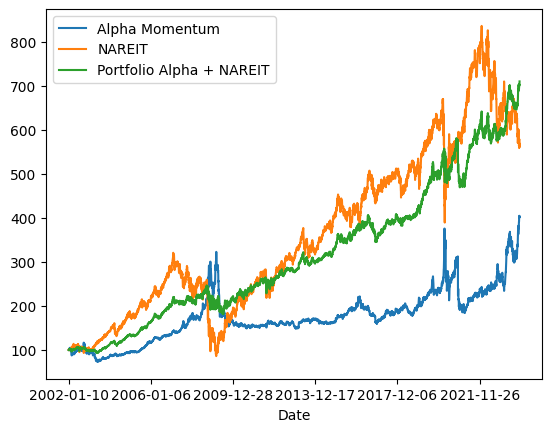

,Ann. Returns,Ann Vol,Sharpe
alpha_return,0.080832,0.180826,0.447014
nareit_return,0.122469,0.289281,0.423356
basket_return,0.101650,0.151722,0.669977


In [60]:
# Convert the returns of the 50-50 basket to the levels (prices) starting at 100 at t = 1 using am.construct_index() and plot the 3 indices using matplotlib
####################### START YOUR CODE #######################
# --- ~5 lines of code ---
strategy_indices['basket_index'] = 100 * (1 + strategy_indices['basket_return']).cumprod() 
for col in ['REIT Alpha Momentum','FTSE NAREIT Index','basket_index']:
    strategy_indices[col].plot.line()
plt.legend(['Alpha Momentum','NAREIT','Portfolio Alpha + NAREIT'])
plt.show()
######################## END YOUR CODE ########################


def get_performance_reit(df):
    mean_returns = df.mean() * 252
    vol_returns = df.std(ddof = 1) * np.sqrt(252)
    sharpe = (mean_returns / vol_returns)

    summary_df = pd.concat([mean_returns, vol_returns, sharpe], axis = 1)
    summary_df.columns = ['Ann. Returns', 'Ann Vol', 'Sharpe']
    return summary_df

# Calcuclate the average annualzied returns, volatility and the sharpe ratio using the function you wrote in Q1.
####################### START YOUR CODE #######################
# --- 1 line of code ---
get_performance_reit(strategy_indices[['alpha_return','nareit_return','basket_return']])
######################## END YOUR CODE ########################

Above, we see that the equally weighted portfolio of NAREIT and Alpha Momentum outperforms both of its constitutent indexes. It has a Sharpe ratio of .67 compared to a Sharpe ratio of .45 and .42 for its two components. The portfolio's annual volatility is .15, which is lower than the Alpha's volatility of .18 and much lower than NAREIT's voloatiliy of .29. 

The portfolio has an annual return of 10.2%, which is higher than Alpha's 8% return but lower than NAREIT's 12.2% return. However, this arithemetic mean return does not take into account the compounding nature of returns, and consequently the impact of "volatility drag". In the chart, we see that the returns of the portfolio are greater than either of their component parts, meaning that the porfolio has a higher geometric mean return than either component. 

Overall, then, we see the clear benefits of diversity in the problem. The portfolio has lower volatility, a higher Sharpe ratio, and higher geometric mean returns than either component index. 